In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/DLS-1/Project"

CROPPED_DIR           = os.path.join(BASE_DIR, "Cropped")
ALIGNED_2PTS_DIR      = os.path.join(BASE_DIR, "Aligned_2")
ALIGNED_3PTS_DIR      = os.path.join(BASE_DIR, "Aligned_3")

CROPPED_LANDMARKS_CSV = os.path.join(BASE_DIR, "cropped_landmarks_celeba.csv")

## Шаг 1

Вычисляем mean face landmarks по всему набору из отобранных, вырезанных и приведенных к разрешению 256x256 10 000 лиц.

Получаем координаты пяти точек, к которым будем приводить при выравнивании изображения лиц. Такой подход обеспечивает статистически обоснованное выравнивание и минимизирует среднее геометрическое искажение при аффинном преобразовании.

Визуализируем эти пять точек для визуального контроля.

In [ ]:
lm_df = pd.read_csv(CROPPED_LANDMARKS_CSV)
print("Total samples:", len(lm_df))

Total samples: 10000


In [ ]:
LM_COLS = [
    "lefteye_x", "lefteye_y",
    "righteye_x", "righteye_y",
    "nose_x", "nose_y",
    "leftmouth_x", "leftmouth_y",
    "rightmouth_x", "rightmouth_y",
]

# shape: (N, 10)
lm_array = lm_df[LM_COLS].values

# reshape -> (N, 5, 2)
lm_array = lm_array.reshape(-1, 5, 2)

mean_face = lm_array.mean(axis=0).astype(np.float32)

print(mean_face)

[[ 87.48447   88.121666]
 [166.43477   86.768326]
 [127.15743  137.41502 ]
 [ 92.74963  168.8511  ]
 [164.03116  167.87447 ]]


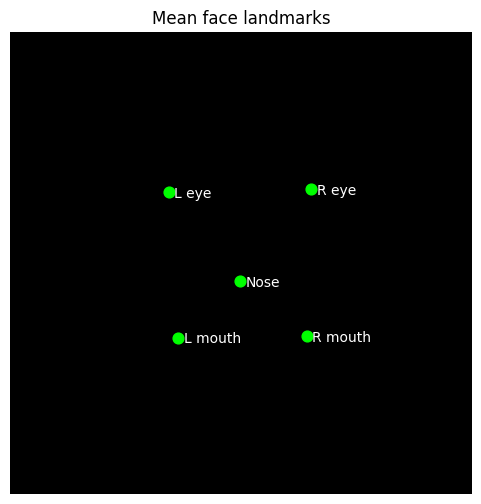

In [ ]:
blank = np.zeros((256, 256, 3), dtype=np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(blank)
plt.scatter(mean_face[:, 0], mean_face[:, 1], c="lime", s=60)

labels = ["L eye", "R eye", "Nose", "L mouth", "R mouth"]
for i, txt in enumerate(labels):
    plt.text(mean_face[i, 0] + 3, mean_face[i, 1] + 3, txt, color="white")

plt.title("Mean face landmarks")
plt.axis("off")
plt.show()

## Шаг 2

Афинное преобразование будем делать по двум точкам (два глаза) и по трем точкам (два глаза и нос). В результате получим два набора выровненных фото в папках Aligned_2 и Aligned_3.

Выполним для теста преобразование пяти случайным образом выбранных лиц из 10 000.

После афинного преобразования обрежем края в соответствии со значением параметра SCALE = 1.4 (в сторону уменьшения, т.е. множитель 1/SCALE). Ранее, при вырезании лиц, мы использовали значение масштаба 1.2. Т.е. теперь мы не только компенсируем дополнительные края, добавленные при вырезании, но и обрезаем дополнительно.

Делаем это с целью, чтобы:
* собственно лицо занимало большый процент площади изображения,
* максимально обрезать черные края, появляющиеся на многих изображениях после афинного преобразования.

Координаты mean face тоже пересчитаем с учетом этой обрезки краев.

In [ ]:
# по этим координатам будем выравнивать лица
print(mean_face[[0, 1, 2]]) # left eye, right eye, nose

[[ 87.48447   88.121666]
 [166.43477   86.768326]
 [127.15743  137.41502 ]]


In [ ]:
def get_landmarks_from_row(row):
    """
    row: pd.Series
    return: np.ndarray shape (5, 2)
    """
    landmarks = np.array([
        [row["lefteye_x"], row["lefteye_y"]],
        [row["righteye_x"], row["righteye_y"]],
        [row["nose_x"], row["nose_y"]],
        [row["leftmouth_x"], row["leftmouth_y"]],
        [row["rightmouth_x"], row["rightmouth_y"]],
    ], dtype=np.float32)

    return landmarks

In [ ]:
OUT_SIZE = 256
SCALE = 1.4

In [ ]:
def align_face_2pts_and_crop_and_resize(img, landmarks, mean_face, out_size=OUT_SIZE, scale=SCALE):
    src_pts = landmarks[[0, 1]].astype(np.float32)
    dst_pts = mean_face[[0, 1]].astype(np.float32)
    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

    return align_face_and_crop_and_resize(img, M, out_size, scale)

def align_face_3pts_and_crop_and_resize(img, landmarks, mean_face, out_size=OUT_SIZE, scale=SCALE):
    src_pts = landmarks[[0, 1, 2]].astype(np.float32)
    dst_pts = mean_face[[0, 1, 2]].astype(np.float32)
    M = cv2.getAffineTransform(src_pts, dst_pts)

    return align_face_and_crop_and_resize(img, M, out_size, scale)

def align_face_and_crop_and_resize(img, affine_m, out_size, scale):
    aligned = cv2.warpAffine(
        img,
        affine_m,
        (out_size, out_size),
        flags=cv2.INTER_LINEAR
    )

    # обрезаем края в соответствии со scale
    crop_size = int(out_size / scale)
    start = (out_size - crop_size) // 2
    end = start + crop_size

    aligned = aligned[start:end, start:end]

    # увеличиваем до out_size × out_size
    aligned = cv2.resize(
        aligned,
        (out_size, out_size),
        interpolation=cv2.INTER_LINEAR
    )

    return aligned

In [ ]:
def adjust_mean_face(mean_face, out_size=OUT_SIZE, scale=SCALE):
    crop_size = out_size / scale
    offset = (out_size - crop_size) / 2
    mean_face_adj = (mean_face - offset) * scale
    return mean_face_adj

In [ ]:
mean_face_adj = adjust_mean_face(mean_face)
print(mean_face_adj)

[[ 71.27825  72.17033]
 [181.80867  70.27565]
 [126.8204  141.18103]
 [ 78.64948 185.19154]
 [178.44362 183.82425]]


In [ ]:
def show_test_samples_plan(n=5):
    for _ in range(n):
        row = lm_df.sample(1).iloc[0]

        img_path = os.path.join(CROPPED_DIR, row['image_id'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        landmarks = get_landmarks_from_row(row)

        aligned2 = align_face_2pts_and_crop_and_resize(img, landmarks, mean_face)
        aligned3 = align_face_3pts_and_crop_and_resize(img, landmarks, mean_face)

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.scatter(landmarks[:,0], landmarks[:,1], c="red")
        plt.title("Before")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(aligned2)
        plt.scatter(mean_face_adj[:,0], mean_face_adj[:,1], c="red")
        plt.title("Mean face aligned by 2pts")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(aligned3)
        plt.scatter(mean_face_adj[:,0], mean_face_adj[:,1], c="red")
        plt.title("Mean face aligned by 3pts")
        plt.axis("off")

        plt.show()

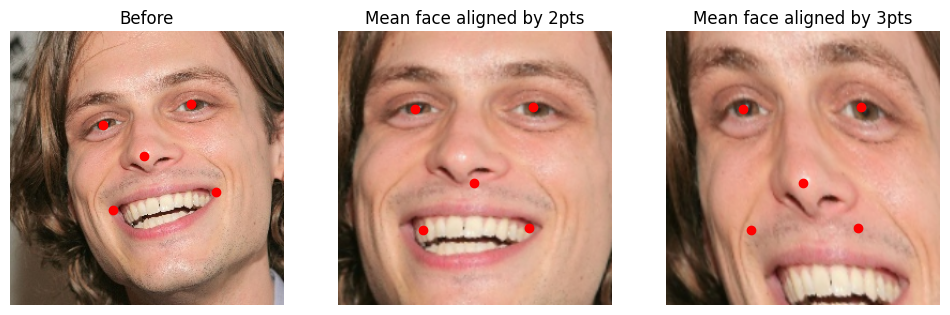

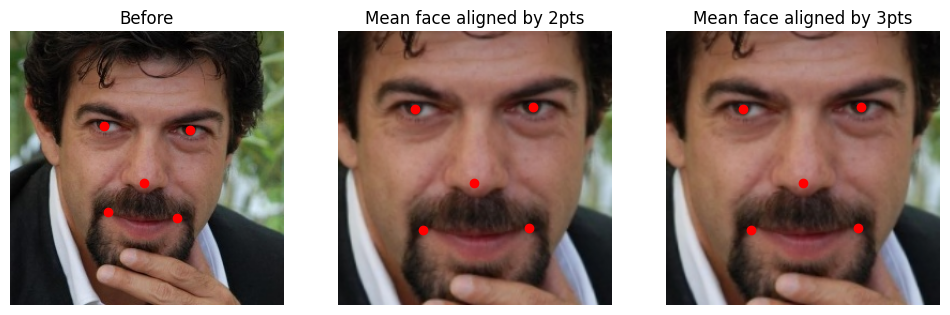

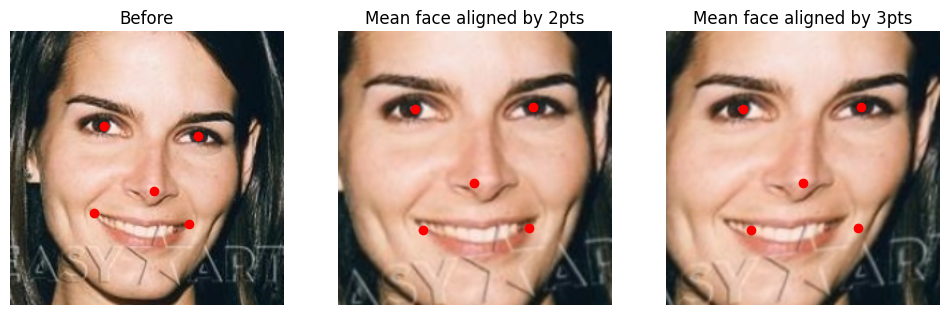

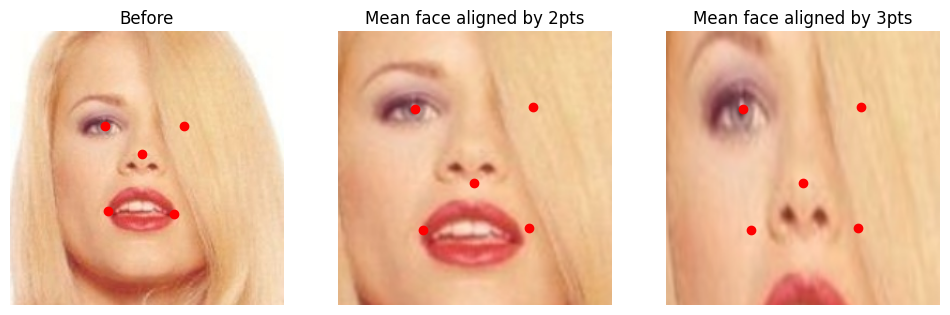

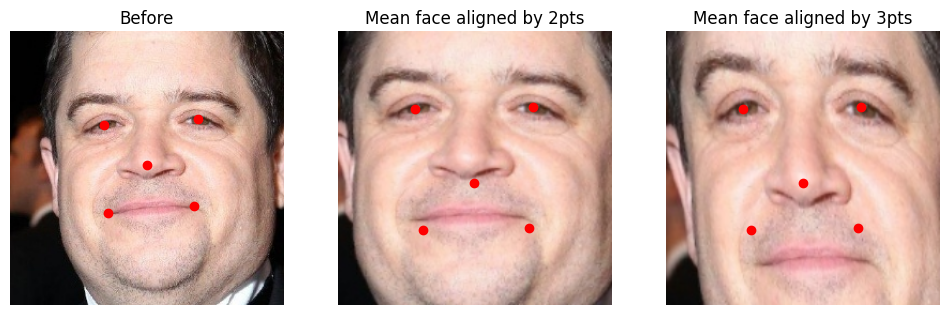

In [ ]:
show_test_samples_plan()

## Шаг 3

Преобразовываем все 10 000 изображений лиц. Сохраняем файлы изображений в папкb Aligned_2 и Aligned_3.

Выполняем визуальный контроль по пяти случайным файлам.

In [ ]:
os.makedirs(ALIGNED_2PTS_DIR, exist_ok=True)
os.makedirs(ALIGNED_3PTS_DIR, exist_ok=True)

In [ ]:
def save_aligned_face(row, mean_face):

    image_id = row['image_id']

    img_path = os.path.join(CROPPED_DIR, image_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    landmarks = get_landmarks_from_row(row)

    aligned = align_face_2pts_and_crop_and_resize(img, landmarks, mean_face)
    save_path = os.path.join(ALIGNED_2PTS_DIR, image_id)
    aligned_bgr = cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, aligned_bgr)

    aligned = align_face_3pts_and_crop_and_resize(img, landmarks, mean_face)
    save_path = os.path.join(ALIGNED_3PTS_DIR, image_id)
    aligned_bgr = cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, aligned_bgr)

In [ ]:
for idx, row in tqdm(lm_df.iterrows(), total=len(lm_df)):
    save_aligned_face(row, mean_face)

100%|██████████| 10000/10000 [49:23<00:00,  3.37it/s]


In [ ]:
def show_test_samples_fact(n=5):
    for _ in range(n):
        row = lm_df.sample(1).iloc[0]

        image_id = row['image_id']

        img_path = os.path.join(CROPPED_DIR, image_id)
        img1 = cv2.imread(img_path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        img_path = os.path.join(ALIGNED_2PTS_DIR, image_id)
        img2 = cv2.imread(img_path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        img_path = os.path.join(ALIGNED_3PTS_DIR, image_id)
        img3 = cv2.imread(img_path)
        img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

        landmarks = get_landmarks_from_row(row)

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(img1)
        plt.scatter(landmarks[:,0], landmarks[:,1], c="red")
        plt.title("Before")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(img2)
        plt.scatter(mean_face_adj[:,0], mean_face_adj[:,1], c="red")
        plt.title("Mean face aligned by 2pts")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(img3)
        plt.scatter(mean_face_adj[:,0], mean_face_adj[:,1], c="red")
        plt.title("Mean face aligned by 3pts")
        plt.axis("off")

        plt.show()

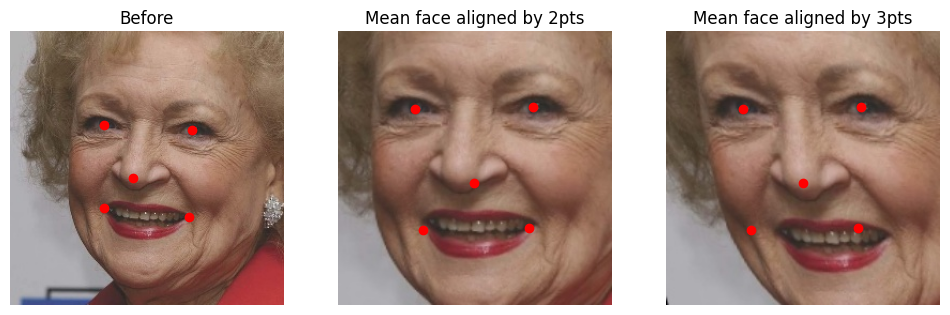

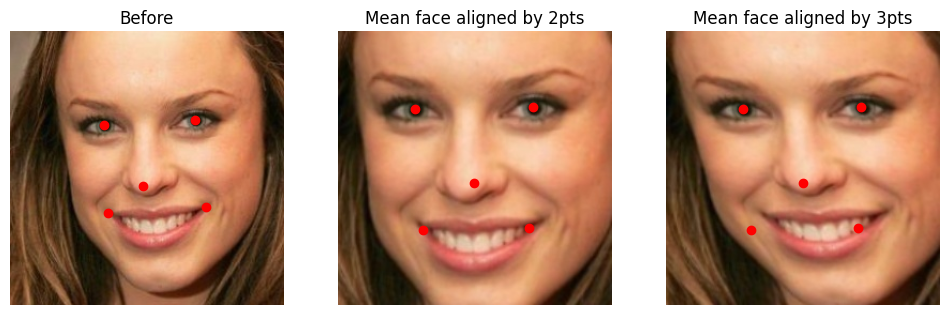

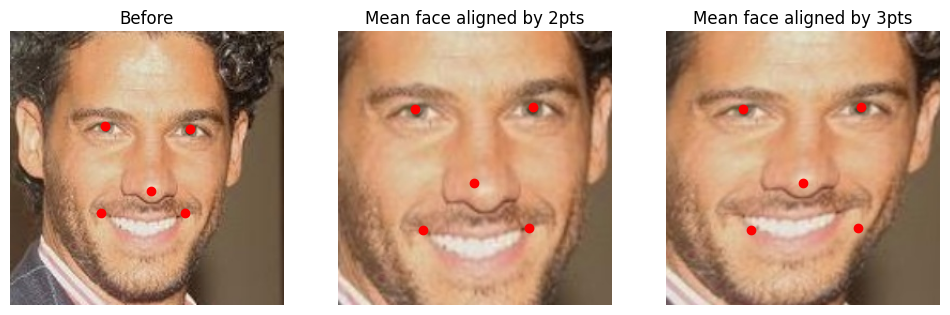

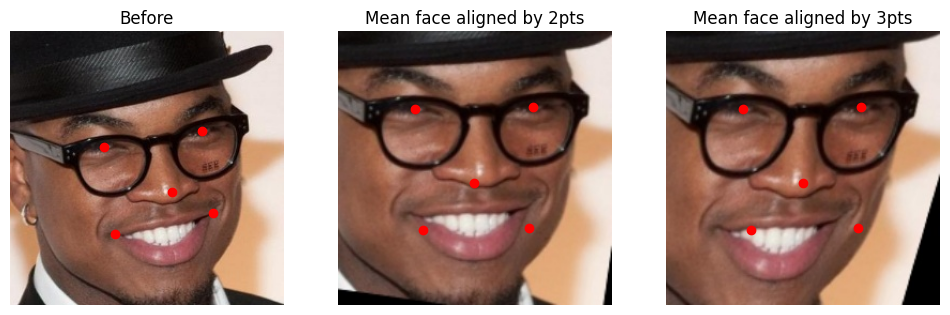

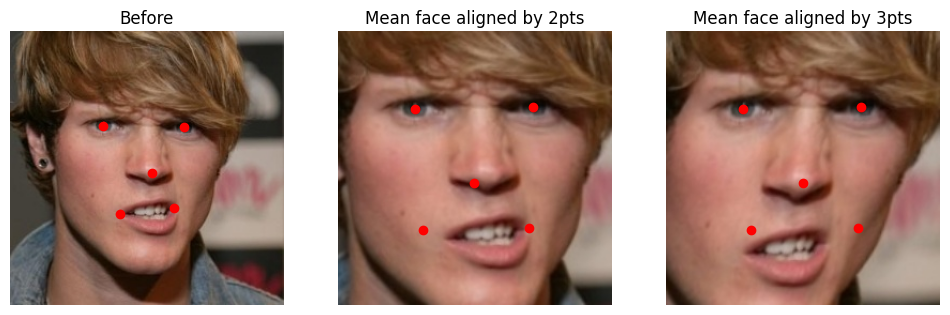

In [ ]:
show_test_samples_fact()